In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/CSE256/FinalProject/

/content/drive/MyDrive/CSE256/FinalProject


In [4]:
!git clone --recursive https://github.com/naigamshah/SelectivePrediction.git

fatal: destination path 'SelectivePrediction' already exists and is not an empty directory.


In [5]:
!ls

data  SelectivePrediction  test.csv  train.csv	val.csv


In [6]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from datasets import load_dataset, concatenate_datasets
import ast
from collections import Counter
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [7]:
RANDOM_SEED = 7
SRC_PREFIX = "squad"
KNOWN_PREFIX = "news"
UNKNOWN_PREFIX = "trivia"

In [8]:
def load(data_prefix, n):
  if data_prefix=="squad":
    return pd.read_csv("data/squad/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  elif data_prefix=="hotpot":
    return pd.read_csv("data/hotpot_qa/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  elif data_prefix=="natural":
    return pd.read_csv("data/natural_questions/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  elif data_prefix=="news":
    return pd.read_csv("data/news_qa/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  if data_prefix=="trivia":
    return pd.read_csv("data/trivia_qa/unmodified.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)

In [9]:
!pwd

/content/drive/MyDrive/CSE256/FinalProject


In [10]:
p_src = load(SRC_PREFIX, 6000)
q_known = load(KNOWN_PREFIX, 2000)
q_unknown = load(UNKNOWN_PREFIX, 4000)

In [11]:
train = pd.concat([p_src.iloc[:1600],q_known.iloc[:1600]]).reset_index(drop=True)
val = pd.concat([p_src.iloc[1600:2000],q_known.iloc[1600:2000]]).reset_index(drop=True)
test = pd.concat([p_src.iloc[2000:6000],q_unknown.iloc[:4000]]).reset_index(drop=True)

In [12]:
def get_ground_answers(dataset):
  ground_answers = []
  for i in tqdm(range(len(dataset))):
    answer = ast.literal_eval(dataset.iloc[i]["answers"])
    if type(answer)==dict:
      ground_answers.append(answer["text"][0].lower())
    else:
      ground_answers.append(answer[0].lower())
  return ground_answers

In [13]:
train["ground_answers"] = get_ground_answers(train)
val["ground_answers"] = get_ground_answers(val)
test["ground_answers"] = get_ground_answers(test)

100%|██████████| 8000/8000 [00:00<00:00, 17985.42it/s]


In [14]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2").cuda()

In [30]:
train

,context,question,answers,ground_answers,predicted_answers,context_question_len,answer_len,sprob_0,sprob_1,sprob_2,sprob_3,sprob_4,eprob_0,eprob_1,eprob_2,eprob_3,eprob_4
0,"It is estimated that in 480 BC, 50 million peo...",The Achaemenid Empire was the known enemy of w...,"{'text': ['the Greek city states'], 'answer_st...",the greek city states,greek city states,145.0,3,0.507306,0.289540,0.190888,0.004427,0.004077,0.436821,0.347218,0.127431,0.064609,0.010438
1,In 2004 he was admitted as knight of the Légio...,Who made Spielberg a knight?,"{'text': ['Jacques Chirac'], 'answer_start': [...",jacques chirac,jacques chirac,100.0,4,0.578032,0.392969,0.010834,0.010484,0.003125,0.975129,0.009883,0.003169,0.003169,0.003169
2,KU Endowment was established in 1891 as Americ...,When was the KU Endowment founded?,"{'text': ['1891'], 'answer_start': [32]}",1891,1891,38.0,2,0.991912,0.004227,0.001795,0.000820,0.000752,0.995959,0.001277,0.001277,0.000962,0.000443
3,2010s saw multiple new sounds in house music d...,Big room house has found increasing popularity...,"{'text': ['2010'], 'answer_start': [1165]}",2010,2010,204.0,1,0.985441,0.012823,0.001362,0.000090,0.000085,0.974002,0.023140,0.001251,0.000556,0.000474
4,"Much of Yale University's staff, including mos...",What union are Yale's service and maintenance ...,{'text': ['Local 35 of the same international'...,local 35 of the same international,local 35,169.0,2,0.897623,0.019142,0.016205,0.015862,0.010387,0.703668,0.234485,0.016681,0.014684,0.006555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,"LOS ANGELES, California (CNN) -- Those extra ...",Which company is launchng the promotion?,['Live Nation'],live nation,<s>which company is launchng the promotion?</s...,552.0,84,0.213940,0.115791,0.094832,0.089162,0.080243,0.321370,0.282295,0.116684,0.071932,0.033847
3196,(MENTAL FLOSS) -- When we think of economic cr...,What kills 99% of horses?,['equine influenza.'],equine influenza.,equine influenza,678.0,3,0.613992,0.252210,0.092683,0.004881,0.003823,0.860460,0.106926,0.005453,0.004912,0.003900
3197,(CNN) -- An Islamic militia took over two stra...,Name of the militia that seized the cities?,['al-Shabaab'],al-shabaab,al-shabaab,302.0,5,0.546335,0.148404,0.126112,0.100829,0.013485,0.521353,0.162643,0.159591,0.047323,0.013949
3198,(CNN) -- The Obama administration announced th...,Who is John Gibler?,['Author'],author,,673.0,-343,0.254501,0.165067,0.118206,0.102484,0.090987,0.212895,0.190244,0.158670,0.129404,0.068673


### Random Forest Calibrator 

In [16]:
def get_calib_data(data):
  predicted_answers = []
  context_question_lens = []
  answer_lens = []
  start_probs_list = []
  end_probs_list = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()

  for i in tqdm(range(len(data))):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    input_ids = inputs["input_ids"].tolist()[0]

    with torch.no_grad(): 
      outputs = model(**inputs)

    start_scores = torch.softmax(outputs.start_logits, dim=1).cuda()
    end_scores = torch.softmax(outputs.end_logits, dim=1).cuda()
    sorted_start, _ = torch.sort(start_scores, descending=True)
    sorted_end, _ = torch.sort(end_scores, descending=True)

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_tokens = all_tokens[torch.argmax(start_scores, dim=1): torch.argmax(end_scores, dim=1) + 1]
    answer = tokenizer.convert_tokens_to_string(answer_tokens)
    
    #New feature set
    context_question_len = torch.Tensor([len(context.split()) + len(question.split())]).cuda()
    answer_len = torch.argmax(end_scores, dim=1).cuda() - torch.argmax(start_scores, dim=1).cuda() + 1
    start_probs = sorted_start[0][:5].cuda()
    end_probs = sorted_end[0][:5].cuda()

    predicted_answers.append(answer.lower().strip())
    context_question_lens.append(context_question_len.cpu().numpy()[0])
    answer_lens.append(answer_len.cpu().numpy()[0])
    start_probs_list.append(start_probs.cpu().numpy())
    end_probs_list.append(end_probs.cpu().numpy())

  start_probs_list = np.asarray(start_probs_list)
  end_probs_list = np.asarray(end_probs_list)

  data["predicted_answers"] = predicted_answers
  data["context_question_len"] = context_question_lens
  data["answer_len"] = answer_lens
  
  for i in range(len(start_probs_list[0])):
    data[f"sprob_{i}"] = start_probs_list[:,i]
  
  for i in range(len(end_probs_list[0])):
    data[f"eprob_{i}"] = end_probs_list[:,i]

  return 

In [17]:
get_calib_data(train)

100%|██████████| 3200/3200 [01:30<00:00, 35.50it/s]


In [18]:
get_calib_data(val)
get_calib_data(test)

100%|██████████| 8000/8000 [03:27<00:00, 38.65it/s]


In [19]:
train.to_csv("train.csv", index = False)
val.to_csv("val.csv", index = False)
test.to_csv("test.csv", index = False)

Training the calibrator

In [20]:
X_train_calib = np.asarray(train.iloc[:,-12:].values)
y_train_calib = np.asarray([0]*(len(X_train_calib)//2) + [1]*(len(X_train_calib)//2))

X_val_calib = np.asarray(val.iloc[:,-12:].values)
y_val_calib = np.asarray([0]*(len(X_val_calib)//2) + [1]*(len(X_val_calib)//2))

X_test_calib = np.asarray(test.iloc[:,-12:].values)
y_test_calib = np.asarray([0]*(len(X_test_calib)//2) + [1]*(len(X_test_calib)//2))


In [21]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_SEED)
rf.fit(X_train_calib, y_train_calib)

RandomForestClassifier(max_depth=4, random_state=7)

In [22]:
preds = rf.predict(X_val_calib)
preds_probs = rf.predict_proba(X_val_calib)

In [23]:
### 0 - answer 
### 1 - abstain

In [24]:
import matplotlib.pyplot as plt


In [25]:
def get_coverage(thresh):
  pred_val = []
  for p0, p1 in preds_probs:
    if p0>thresh:
      pred_val.append(0)
    else:
      pred_val.append(1)

  cntr = Counter(pred_val)
  coverage = cntr[0]/(cntr[0]+cntr[1])
  return coverage


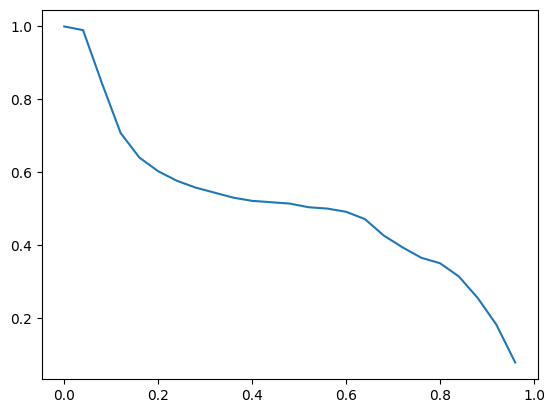

In [26]:
thresholds = [x/100 for x in range(0,100,4)]
coverages = []
for thresh in thresholds:
  coverages.append(get_coverage(thresh))

plt.plot(thresholds,coverages)

In [27]:
pred_val = []

THRESH = 0.6
for p0, p1 in preds_probs:
  if p0>THRESH:
    pred_val.append(0)
  else:
    pred_val.append(1)

cntr = Counter(pred_val)
print(f"Coverage: {cntr[0]/(cntr[0]+cntr[1])}")

Coverage: 0.49125


### Distance Based Baseline

In [ ]:
# check the distance between the question and context with 2 clusters in train, find which cluster it's closest to

In [32]:
# convert train into a matrix of tokens
def create_train_matrix(data):
  train_matrix = []
  for i in range(len(data)):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True, max_length=512)["input_ids"].numpy()[0]
    num_to_pad = 512 - len(inputs)
    inputs = np.pad(inputs, (0, num_to_pad), 'constant')
    train_matrix.append(inputs)

  train_matrix = np.array(train_matrix).reshape(len(data), 512)

  # first 1600 answer, else abstain
  answer_train_matrix, abstain_train_matrix = train_matrix[0:1600, :], train_matrix[1600:len(train_matrix), :]  
  return answer_train_matrix, abstain_train_matrix

answer_train_matrix, abstain_train_matrix = create_train_matrix(train)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def get_preds(data):
  preds = []
  for i in tqdm(range(len(data))):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True, max_length=512)["input_ids"].numpy()[0]
    num_to_pad = 512 - len(inputs)
    inputs = np.pad(inputs, (0, num_to_pad), 'constant')
    inputs = np.expand_dims(inputs, axis=0)

    answer_cosine_sim = np.amax(cosine_similarity(answer_train_matrix, inputs))
    abstain_cosine_sim = np.amax(cosine_similarity(abstain_train_matrix, inputs))
    if answer_cosine_sim > abstain_cosine_sim:
      # more similar to the answer matrix
      preds.append(0)
    else:
      preds.append(1)

  return np.array(preds)

In [38]:
val_cosine_preds = get_preds(val)

100%|██████████| 800/800 [00:14<00:00, 53.94it/s]


In [39]:
# validation set accuracy 
np.sum(y_val_calib == val_cosine_preds) / len(y_val_calib)

0.97375

In [40]:
test_cosine_preds = get_preds(test)

100%|██████████| 8000/8000 [02:37<00:00, 50.93it/s]


In [41]:
# test set accuracy 
np.sum(y_test_calib == test_cosine_preds) / len(y_test_calib)

0.5775

In [ ]:
# def get_coverage(cosine_preds, thresh=0):
#   maxes = np.amax(cosine_preds, axis = 1)
#   preds = np.asarray([0 if val > thresh else 1 for val in maxes])

#   cntr = Counter(preds)
#   coverage = cntr[0]/(cntr[0]+cntr[1])
#   return coverage


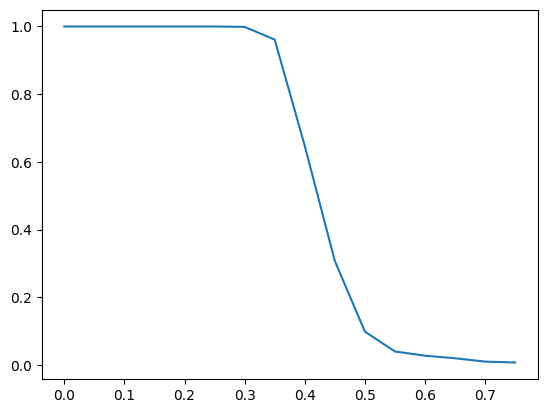

In [ ]:
# thresholds = [x/100 for x in range(0,80,5)]
# coverages = []
# for thresh in thresholds:
#   coverages.append(get_coverage(val_cosine_preds, thresh))

# plt.plot(thresholds,coverages)

In [ ]:
cntr = Counter(preds)
coverage = cntr[0]/(cntr[0]+cntr[1])

In [ ]:
cntr

Counter({0: 406, 1: 394})

In [ ]:
coverage

0.5075

Ignore code from here

In [ ]:
accuracy = accuracy_score(combined_df.ground_answers.values,combined_df.predicted_answers.values)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58


Training Calibrator

In [ ]:
X = np.asarray(combined_df.iloc[:, :12].values)
y = np.asarray([0]*1600 + [1]*400)

X_train = np.concatenate((X[:1300],X[1600:1900]))
y_train = np.concatenate((y[:1300],y[1600:1900]))
X_val = np.concatenate((X[1300:1600],X[1900:]))
y_val = np.concatenate((y[1300:1600],y[1900:]))

# shuffled_indices_train = np.random.permutation(len(X_train))
# shuffled_indices_val = np.random.permutation(len(X_val))

# X_train, y_train = X_train[shuffled_indices_train], y_train[shuffled_indices_train]
# X_val, y_val = X_val[shuffled_indices_val], y_val[shuffled_indices_val]

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=7)

In [ ]:
preds = rf.predict(X_val)
preds_probs = rf.predict_proba(X_val)

In [ ]:
pred_val = []
THRESH = 0.1
for p0, p1 in preds_probs:
  if p0>THRESH:
    pred_val.append(0)
  else:
    pred_val.append(1)

cntr = Counter(pred_val)
print(f"Coverage: {cntr[0]/(cntr[0]+cntr[1])}")

Coverage: 0.9675


In [ ]:
def get_indices(indices):
  ret = []
  for i in indices:
    if i<=300:
      ret.append(i+1300)
    else:
      ret.append(i-300+1900)

  return ret

In [ ]:
indices = [index for index, value in enumerate(pred_val) if value == 0]
new_indices = get_indices(indices)

In [ ]:
val_answers = combined_df[['ground_answers', 'predicted_answers']].iloc[new_indices]

In [ ]:
accuracy = accuracy_score(val_answers.ground_answers.values,val_answers.predicted_answers.values)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


In [ ]:
def acc_vs_threshold()

Don't bother about the code below!!

In [ ]:
# print(context, question)
inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
# print(input_ids)
outputs = model(**inputs)
# print(f"Outputs: {outputs}")
start_scores = outputs.start_logits
end_scores = outputs.end_logits
print(start_scores)

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(f"all tokens: {all_tokens}")
print(torch.argmax(start_scores, dim=1).item(), torch.argmax(end_scores, dim=1).item())
answer_tokens = all_tokens[torch.argmax(start_scores, dim=1).item(): torch.argmax(end_scores, dim=1).item() + 1]
print(answer_tokens)
answer = tokenizer.convert_tokens_to_string(answer_tokens)
print(answer)

tensor([[-0.1727,  0.1722,  0.1962, -0.2241, -0.1423, -0.3767,  0.1245,  0.2492,
          0.4291,  0.1370, -0.0882,  0.1542,  0.2131,  0.1711,  0.3439,  0.4369,
          0.3794,  0.1264,  0.1803,  0.3830,  0.1362,  0.1255, -0.2212,  0.2080,
         -0.1640, -0.0518, -0.1869,  0.0849,  0.0730,  0.2436, -0.0123,  0.2799,
          0.3926,  0.3879,  0.3484,  0.0104,  0.0549,  0.1858, -0.2647, -0.1953,
         -0.5426,  0.0092,  0.2475, -0.2115,  0.2824,  0.1898, -0.1397,  0.2071,
         -0.0716,  0.1541,  0.3763,  0.0816, -0.0554,  0.0924,  0.2390,  0.1332,
          0.1850,  0.0293,  0.1409, -0.1875,  0.1431, -0.1129, -0.1109, -0.0025,
         -0.2622, -0.3049,  0.1145, -0.0463,  0.0945, -0.2147, -0.1032,  0.0914,
          0.0907,  0.0529,  0.2493,  0.2475, -0.2520, -0.2170, -0.4816,  0.0764,
          0.2737, -0.0024, -0.3389,  0.0297,  0.0574,  0.1878,  0.1136,  0.1683,
          0.0771,  0.0660,  0.2494,  0.1959,  0.0416,  0.1995,  0.3805,  0.4478,
          0.5131,  0.0806,  

In [ ]:
out = tokenizer(context, question, return_tensors = "pt")

In [ ]:
out

{'input_ids': tensor([[  101,  1135,  1110,  3555,  1115,  1107, 18478,  3823,   117,  1851,
          1550,  1234,  2077,  1107,  1103,   138,  7147,  5521, 21462,  1181,
          2813,   119,  1109,  8207,  1120,  1157,  4709,  4741,  1166,  3140,
           110,  1104,  1103,  1362,   112,   188,  1416,   117,  1103,  2439,
          1216,  2482,  1111,  1251,  8207,  1107,  1607,   119,  1130,  2414,
          1607,   117,  1103,   138,  7147,  5521, 21462,  1181,  2813,  1110,
          1737,  1112,  1103, 19173,  1104,  1103,  2414,  1331,  2231,   117,
          1111,  1103,  9712, 25305,  1104,  6864,  1259,  1103,  2778,  8879,
          1116,  1107, 19014,   117,  1459,  6557,  1116,  1216,  1112,  1812,
          1105, 14889,  2344,   117,  1105,  1103,  1329,  1104,  1126,  2078,
          1846,   117,  1103,  4849, 25692,  1918,  1596,   117,  2032,  1157,
          6835,   119,  1109,  8207,  1125,   170, 25864,   117, 18561, 21611,
          3469,  1223,  1103,  6821,  

In [ ]:
model(**out)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.0429,  0.1648, -0.1192, -0.0276, -0.2173,  0.1022,  0.1067,  0.3181,
          0.0166,  0.1815,  0.3874,  0.4361,  0.4217,  0.0552,  0.1394,  0.1310,
         -0.1659, -0.0616, -0.2787,  0.1007,  0.3279, -0.2475,  0.2782,  0.2465,
         -0.1590,  0.2153, -0.0095,  0.2838,  0.4865,  0.1575,  0.0668,  0.1679,
          0.2389,  0.2207,  0.1624,  0.0291,  0.2366, -0.1136,  0.1844, -0.0036,
         -0.1253,  0.0994, -0.1494, -0.2550,  0.1871,  0.0508,  0.0787, -0.2512,
         -0.0849,  0.1713,  0.0763,  0.1220,  0.2671,  0.1983, -0.2871, -0.1777,
         -0.4162,  0.0997,  0.3504,  0.0389, -0.2530,  0.1223,  0.1393,  0.2592,
          0.1067,  0.1923,  0.1520,  0.1548,  0.2749,  0.2830,  0.0829,  0.2386,
          0.3872,  0.3903,  0.4959,  0.1011,  0.2967,  0.2100,  0.0809,  0.0741,
          0.2501,  0.1622,  0.1860,  0.1131,  0.5484,  0.4027,  0.5341,  0.7941,
          0.5851,  0.2569,  0.5496,  0.3578,  0.4035, -0

In [ ]:
df = pd.read_csv("data/news_qa/train.csv")

In [ ]:
df.head()

,context,question,answers,key,labels
0,"NEW DELHI, India (CNN) -- A high court in nort...",What was the amount of children murdered?,['19'],da0e6b66e04d439fa1ba23c32de07e50,"[{'end': array([295]), 'start': array([294])}]"
1,"NEW DELHI, India (CNN) -- A high court in nort...",When was Pandher sentenced to death?,['February.'],724f6eb9a2814e4fb2d7d8e4de846073,"[{'end': array([269]), 'start': array([261])}]"
2,"NEW DELHI, India (CNN) -- A high court in nort...",The court aquitted Moninder Singh Pandher of w...,['rape and murder'],d64cbb90e5134081acfa83d3e702408c,"[{'end': array([638]), 'start': array([624])}]"
3,"NEW DELHI, India (CNN) -- A high court in nort...",who was acquitted,['Moninder Singh Pandher'],fd7177ee6f1f4d62becd983a0305f503,"[{'end': array([216]), 'start': array([195])}]"
4,"NEW DELHI, India (CNN) -- A high court in nort...",who was sentenced,['Moninder Singh Pandher'],cd25c69f631349748ccdeccaace66463,"[{'end': array([216]), 'start': array([195])}]"


In [ ]:
p_src

,context,question
0,"It is estimated that in 480 BC, 50 million peo...",The Achaemenid Empire was the known enemy of w...
1,In 2004 he was admitted as knight of the Légio...,Who made Spielberg a knight?
2,KU Endowment was established in 1891 as Americ...,When was the KU Endowment founded?
3,2010s saw multiple new sounds in house music d...,Big room house has found increasing popularity...
4,"Much of Yale University's staff, including mos...",What union are Yale's service and maintenance ...
...,...,...
1595,"In early times, the privilege of papal electio...",Why did the ceromony of consecrating a bishop ...
1596,Commercial turkeys are usually reared indoors ...,How much more does a average commercial turke...
1597,Nonverbal communication describes the process ...,What is an example of an involuntary intent of...
1598,The languages have not undergone the deliberat...,What language family is Czech?
